In [1]:
import pandas as pd
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict, Counter
from tqdm import tqdm

In [19]:
doc_quality = []
line_labels = []
line_scores = []

#lang_id = "por_Latn"
#datasets = ["1_000", "1_001", "1_002", "1_003", "1_004", "1_005"]

lang_id = "eng_Latn"
datasets = ["1_00"]

#lang_id = "ita_Latn"
#datasets = ["1_000", "1_001", "1_002", "1_003", "1_004", "1_005"]

#lang_id = "fin_Latn"
#datasets = ["1_002", "1_003", "1_004", "1_005", "1_006", "1_007"]

for d in datasets:
    if lang_id == "eng_Latn":
        og_data_path = Path(f"../data/hplt/eng_Latn_small_sample/{d}.jsonl")
    else:
        og_data_path = Path(f"../data/hplt/{lang_id}/{d}.jsonl")
    line_data_path = Path(f"../data/hplt/line_quality_labelled/{lang_id}/full/{d}.jsonl")
    with og_data_path.open("r") as og_data, line_data_path.open("r") as line_data:
        for i, j in zip(og_data, line_data):
            og = json.loads(i)
            line = json.loads(j)

            # Check that doc ids match
            assert og["id"] == line["id"]
            
            doc_quality.append(og["doc_scores"][0])
            line_labels.append(line["line_quality_labels"])
            try:
                line_scores.append(line["quality_scores"])
            except:
                line_scores.append(line["quality_score"])
            if len(doc_quality) == 100_000:
                break
        

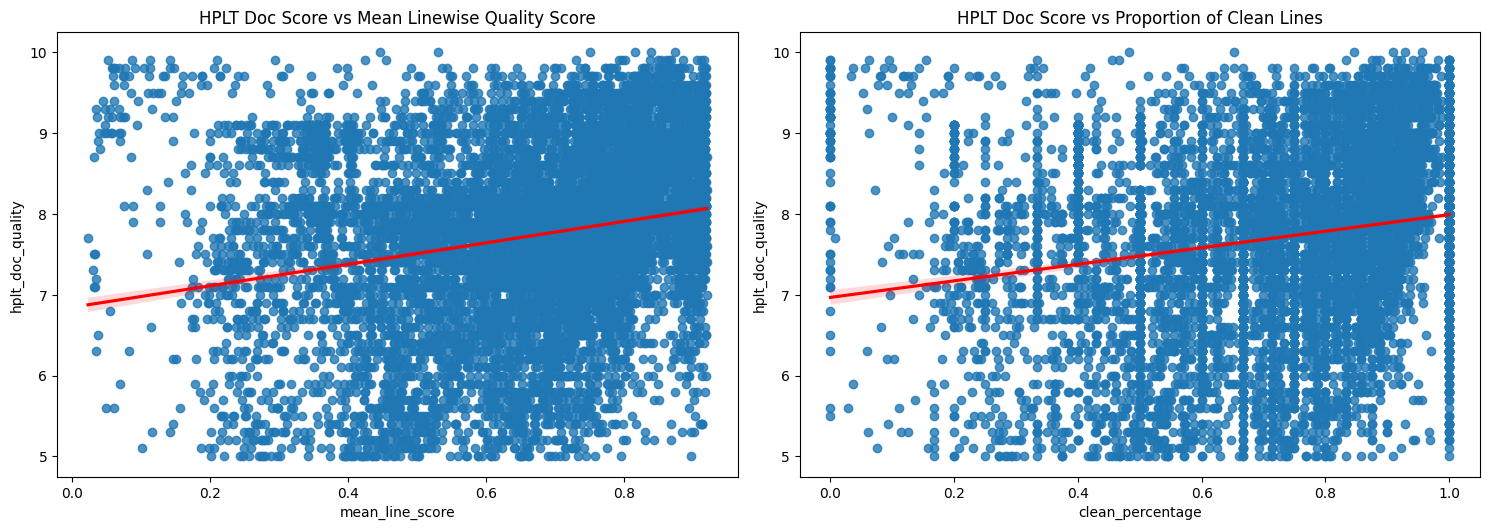

In [3]:
def analyze_quality_correlation(doc_quality, line_labels, line_scores, do_save=True):
    """
    Analyze correlation between document-level quality and line-level quality scores.
    
    Args:
        documents: List of dictionaries, each containing doc_quality, line_quality_labels, quality_score
    
    Returns:
        DataFrame with correlation analysis results
    """
    # Create a DataFrame to store the results
    results = []
    
    for doc_quality, line_labels, line_scores in zip(doc_quality, line_labels, line_scores):
        
        # Calculate various aggregation metrics
        mean_line_score = np.mean(line_scores)
        median_line_score = np.median(line_scores)
        min_line_score = np.min(line_scores)
        clean_percentage = sum(1 for label in line_labels if label == "Clean") / len(line_labels)
                
        results.append({
            'hplt_doc_quality': doc_quality,
            'mean_line_score': mean_line_score,
            'median_line_score': median_line_score,
            'min_line_score': min_line_score,
            'clean_percentage': clean_percentage,
        })
    
    df = pd.DataFrame(results)
    
    # Calculate correlations with doc_quality
    correlations = {}
    for col in df.columns:
        if col != 'hplt_doc_quality':
            pearson, p_value = pearsonr(df['hplt_doc_quality'], df[col])
            correlations[col] = {
                'pearson': pearson,
                'p_value': p_value
            }
    
    # Visualize key relationships
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    sns.regplot(x='mean_line_score', y='hplt_doc_quality', data=df, line_kws=dict(color="r"))
    plt.title('HPLT Doc Score vs Mean Linewise Quality Score')

    plt.subplot(2, 2, 2)
    sns.regplot(x='clean_percentage', y='hplt_doc_quality', data=df, line_kws=dict(color="r"))
    plt.title('HPLT Doc Score vs Proportion of Clean Lines')

    plt.tight_layout()

    if do_save:
        plt.savefig(f"../figures/{lang_id}_doc_quality_vs_line_quality")

    plt.show()
    
    return df, correlations

df, correlations = analyze_quality_correlation(doc_quality, line_labels, line_scores, do_save=False)

In [30]:
def analyze_cleanliness(items):
    total_items = len(items)
    clean_count = items.count("Clean")
   
    if clean_count >= (2/3) * total_items:
        return "Clean"
    elif clean_count > (1/3) * total_items:
        return "Mixed"
    else:
        return "Non-Clean"

majority_labels = [analyze_cleanliness(l) for l in line_labels]

In [33]:
majority_labels.count("Non-Clean")

7959

In [5]:
correlations

{'mean_line_score': {'pearson': 0.3317423418860762, 'p_value': 0.0},
 'median_line_score': {'pearson': 0.28169421931408906, 'p_value': 0.0},
 'min_line_score': {'pearson': 0.15458014201562129, 'p_value': 0.0},
 'clean_percentage': {'pearson': 0.3012702676491753, 'p_value': 0.0}}

In [34]:
df = pd.read_csv("../data/nemotron_quality_predictions.csv")
df

,text,nemotron_label,hplt_doc_score
0,"3e9\nLast week, the man who washed my hair in ...",Medium,7.1
1,Mona Abhari is headed to the Iowa State Capito...,High,8.1
2,Spider-Man and Marvel Cinematic Universe fans ...,Medium,8.1
3,Candidates are set to take the stage for anoth...,Medium,8.5
4,It looks Maisie Williams’s faceless assassin s...,Medium,8.0
...,...,...,...
99995,ПyблиkyeTcя Ha языke:\n-\nMight be uploading c...,Low,5.2
99996,ПyблиkyeTcя Ha языke:\n-\nGO TO HELL\nПyблиkye...,Low,6.2
99997,ПyблиkyeTcя Ha языke:\n-\nYes. I was pleasantl...,Low,5.0
99998,This week on the Official Brotherhood of Xûr P...,Medium,5.2


In [35]:
df["linewise_quality"] = majority_labels
df

,text,nemotron_label,hplt_doc_score,linewise_quality
0,"3e9\nLast week, the man who washed my hair in ...",Medium,7.1,Clean
1,Mona Abhari is headed to the Iowa State Capito...,High,8.1,Clean
2,Spider-Man and Marvel Cinematic Universe fans ...,Medium,8.1,Clean
3,Candidates are set to take the stage for anoth...,Medium,8.5,Clean
4,It looks Maisie Williams’s faceless assassin s...,Medium,8.0,Clean
...,...,...,...,...
99995,ПyблиkyeTcя Ha языke:\n-\nMight be uploading c...,Low,5.2,Non-Clean
99996,ПyблиkyeTcя Ha языke:\n-\nGO TO HELL\nПyблиkye...,Low,6.2,Non-Clean
99997,ПyблиkyeTcя Ha языke:\n-\nYes. I was pleasantl...,Low,5.0,Non-Clean
99998,This week on the Official Brotherhood of Xûr P...,Medium,5.2,Mixed


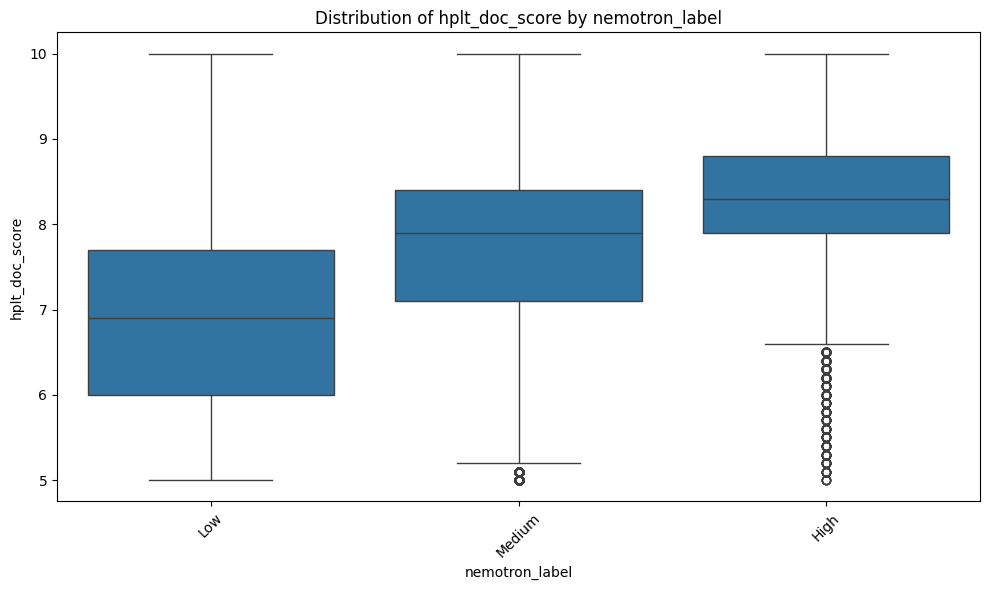

In [36]:
# Boxplot - Shows distribution statistics across categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='nemotron_label', y='hplt_doc_score', data=df, order=['Low', 'Medium', 'High'])
plt.title('Distribution of hplt_doc_score by nemotron_label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../figures/eng_Latn_nemotron_label_vs_hplt_doc_score")
plt.show()

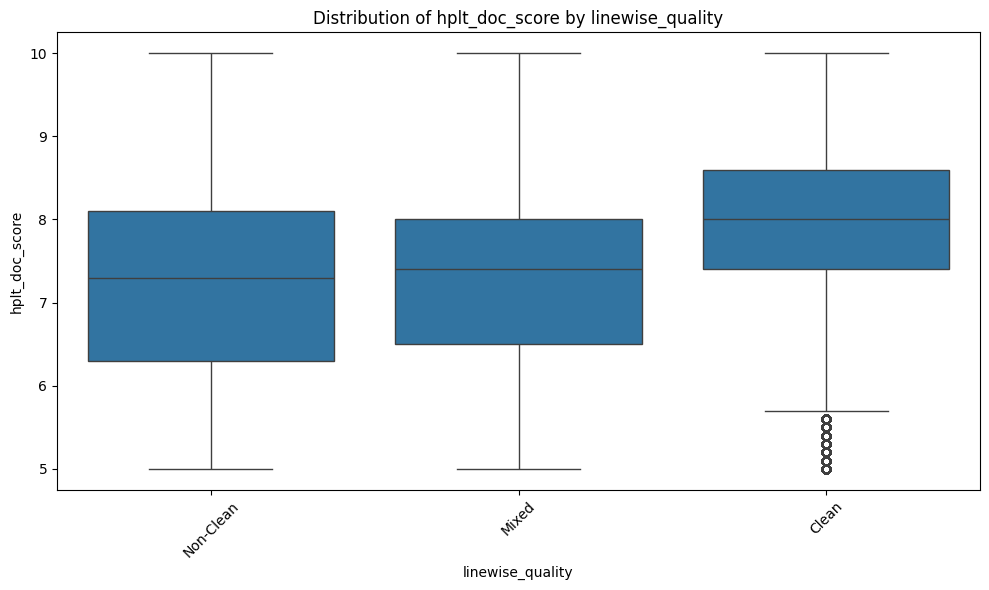

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='linewise_quality', y='hplt_doc_score', data=df, order=["Non-Clean", "Mixed", "Clean"])
plt.title('Distribution of hplt_doc_score by linewise_quality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../figures/eng_Latn_nemotron_label_vs_linewise_quality")
plt.show()

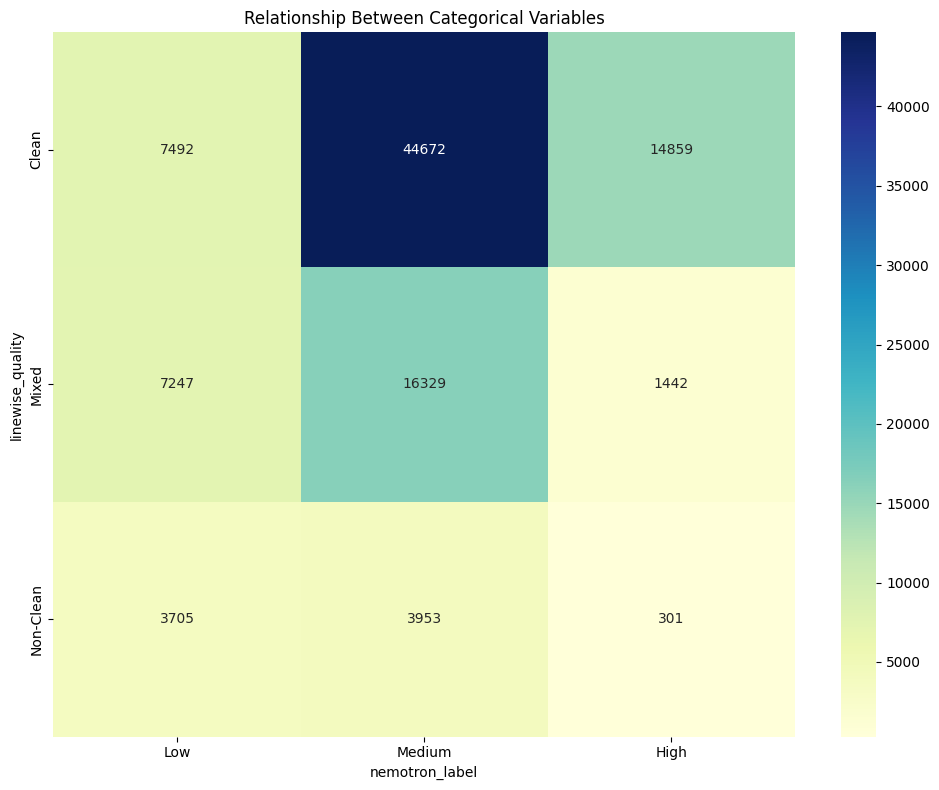

In [39]:
# Assuming your dataframe is called 'df' with categorical columns 'cat1' and 'cat2'
# Create a cross-tabulation
cross_tab = pd.crosstab(df['linewise_quality'], df['nemotron_label'])
# Reorder rows and columns
cross_tab = cross_tab.reindex(index=["Clean", "Mixed","Non-Clean"], columns=["Low", "Medium", "High"])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Relationship Between Categorical Variables')
plt.tight_layout()
plt.show()